## Feature ranking with elimination

In [2]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from pathlib import Path
import numpy as np
import pandas as pd

from pathlib import Path
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
import numpy as np
import multiprocessing as mp

from pathlib import Path
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
import numpy as np

import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


from matplotlib import pyplot as plt


In [3]:
%load_ext memory_profiler

In [3]:
def get_scoring_funtion_polarity(scoring):
    polarity = {
        "neg_mean_absolute_error": False,
        "neg_mean_squared_error": False,

        "neg_root_mean_squared_error": True,
        "neg_mean_squared_log_error": False,
        "neg_median_absolute_error": False,
        "r2": True,
        "neg_mean_poisson_deviance": False,
        "neg_mean_gamma_deviance": False,
        "neg_mean_absolute_percentage_error": False
    }
    if scoring not in polarity:
        err_msg = scoring + " metric in not supported. Please choose a metric from: "+str(polarity.keys())
        raise Exception(err_msg) 
    return polarity[scoring]

def get_score_without_feature(X, y, features_to_drop, scoring, model,n_splits=3):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=3)
    cv_scores = cross_val_score(model, X.drop(features_to_drop, axis=1).values, y.values, cv=kf, scoring=scoring, n_jobs=-1)
    mean_score = np.mean(cv_scores)
    print("features_to_drop",features_to_drop,"mean_score",mean_score)
    return mean_score


def find_least_important_feature(X, y, scoring, model, n_splits):
    is_polarity_positive = get_scoring_funtion_polarity(scoring)
    intermediate_results = {}
    for featureindex, feature_name in enumerate(X.columns):
        score_without_feature = get_score_without_feature(X, y, feature_name, scoring, model, n_splits)
        intermediate_results[feature_name] = score_without_feature

    # calculate the results        
    if is_polarity_positive:
        lowest_feature = None
        lowest_score = -99999
        for feature_name in intermediate_results.keys():
            score_without_feature = intermediate_results[feature_name]
            if score_without_feature >= lowest_score:
                lowest_score = score_without_feature
                lowest_feature = feature_name
            del score_without_feature
    else:
        lowest_feature = None
        lowest_score = 99999
        for feature_name in intermediate_results.keys():
            score_without_feature = intermediate_results[feature_name]
            if score_without_feature <= lowest_score:
                lowest_score = score_without_feature
                lowest_feature = feature_name
            del score_without_feature
    print("lowest_feature",lowest_feature,"lowest_score",lowest_score)
    results = {}
    results["lowest_score"] = lowest_score
    results["lowest_feature"] = lowest_feature
    results["intermediate_results"] = intermediate_results
    del intermediate_results
    del lowest_feature
    del lowest_score
    return results

def feature_ranking_elimination(X, y, min_features_required, scoring, model, n_splits):
    results = {}
    current_total_feature = X.shape[1]

    count = 1
    print("Staring experiment for: ", current_total_feature)
    results[current_total_feature] = find_least_important_feature(X, y, scoring, model, n_splits)
    print("lowest feature drop: ",results[current_total_feature]["lowest_feature"])
    current_X = X.drop(results[current_total_feature]["lowest_feature"], axis=1)
    current_total_feature = current_X.shape[1]

    count = count + 1
    while (current_total_feature > min_features_required):
        print("Staring experiment for: ", current_total_feature)
        results[current_total_feature] = find_least_important_feature(current_X, y, scoring, model, n_splits)
        print("Results of ", str(count), " iteration:", results[current_total_feature]["lowest_score"])
        print("lowest feature drop: ",results[current_total_feature]["lowest_feature"])
        current_X = current_X.drop(results[current_total_feature]["lowest_feature"], axis=1)
        current_total_feature = current_X.shape[1]
        count = count + 1

    return results


In [4]:
# ##parallel implementation 
# def get_score_without_feature(X, y, features_to_drop, scoring, n_splits=3, gpu_id=0):
#     model=XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist', gpu_id=gpu_id, n_jobs=1)
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=3)
#     cv_scores = cross_val_score(model, X.drop(features_to_drop, axis=1).values, y.values, cv=kf, scoring=scoring, n_jobs=-1)
#     mean_score = np.mean(cv_scores)
#     print("features_to_drop",features_to_drop,"mean_score",mean_score)
#     return features_to_drop, mean_score
# def find_least_important_feature(X, y, scoring, model, n_splits):
#     is_polarity_positive = get_scoring_funtion_polarity(scoring)
#     intermediate_results = {}
#     jobs = []
#     for featureindex, feature_name in enumerate(X.columns):
#         jobs.append((X, y, feature_name, scoring, n_splits, featureindex%4))
#     with mp.Pool(processes=4) as pool:
#         results = pool.starmap(get_score_without_feature, jobs)
#     for result in results:
#         intermediate_results[result[0]] = result[1]
#     # calculate the results        
#     if is_polarity_positive:
#         lowest_feature = None
#         lowest_score = -99999
#         for feature_name in intermediate_results.keys():
#             score_without_feature = intermediate_results[feature_name]
#             if score_without_feature >= lowest_score:
#                 lowest_score = score_without_feature
#                 lowest_feature = feature_name
#             del score_without_feature
#     else:
#         lowest_feature = None
#         lowest_score = 99999
#         for feature_name in intermediate_results.keys():
#             score_without_feature = intermediate_results[feature_name]
#             if score_without_feature <= lowest_score:
#                 lowest_score = score_without_feature
#                 lowest_feature = feature_name
#             del score_without_feature
#     print("lowest_feature",lowest_feature,"lowest_score",lowest_score)
#     results = {}
#     results["lowest_score"] = lowest_score
#     results["lowest_feature"] = lowest_feature
#     results["intermediate_results"] = intermediate_results
#     del intermediate_results
#     del lowest_feature
#     del lowest_score
#     return results

## Recursive feature elimination with cross-validation


In [5]:
%%time
%%memit

input_files = [
    Path("../data/formated_dataset.csv"),
    Path("../data/scaler_df.csv"),
    Path("../data/quantile_df.csv"),
]


input_file = input_files[2]
print("Input file: ",input_file)
df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]


Input file:  ../data/quantile_df.csv
peak memory: 542.91 MiB, increment: 388.16 MiB
CPU times: user 3.36 s, sys: 302 ms, total: 3.67 s
Wall time: 3.77 s


In [6]:
# Reduce input size for debugging
# dff = df[:2000]

In [14]:
# %%time
# %%memit
# min_features_required=3
# model=XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
# n_splits=3
# scorings = ["r2", "neg_mean_absolute_error", "neg_mean_squared_error", "neg_root_mean_squared_error", "neg_mean_squared_log_error", "neg_median_absolute_error", "neg_mean_poisson_deviance", "neg_mean_gamma_deviance", "neg_mean_absolute_percentage_error"]

# for scoring in scorings:
#     y = df['target']
#     X = df.drop("target",axis=1)
#     print("Scoring funtion: ",scoring)
#     results = feature_ranking_elimination(X,y, min_features_required, scoring, model, n_splits)
    
#     output_file_name = str(input_file.stem)+"_"+scoring+"_1feb.pkl"
#     file = open(output_file_name, 'wb')
#     pickle.dump(results, file)
#     file.close()


#     plot_1_data = []
#     for exp_no in results.keys():
#             plot_1_data.append((exp_no,results[exp_no]["lowest_score"]))

#     plt.scatter(*zip(*plot_1_data))
#     plt.gca().invert_xaxis()
#     # plt.ylim(0,0.5)
#     plt.xlabel("Number of features in this experiment")
#     plt.ylabel("Score for the weakest the feature")
#     plt.show()

## Testing r2

Scoring funtion:  r2
Staring experiment for:  47
features_to_drop relief_elev_focalrange1000m_3s mean_score 0.7708813766900241
features_to_drop LONGITUDE_GRID1_clip mean_score 0.7621806964192569
features_to_drop LOC_distance_to_coast mean_score 0.768087614778497
features_to_drop ceno_euc_aust1 mean_score 0.7712089824881936
features_to_drop clim_EPA_albers mean_score 0.7707677066296746
features_to_drop be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata mean_score 0.7715139018304945
features_to_drop relief_roughness mean_score 0.771112063480358
features_to_drop be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata mean_score 0.7701229458732627
features_to_drop be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata mean_score 0.7706806798782395
features_to_drop dem_fill mean_score 0.7683129995958856
features_to_drop Dose_2016 mean_score 0.7705190787236496
features_to_drop be-30y-85m-avg-GREEN.filled.lzw.nodata mean_score 0.7703263670738201
features_to_drop be-30y-85m-avg_BLUE+SWIR2 mean_score 0.7709147867408138
f

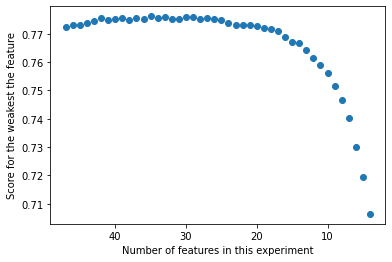

In [7]:
min_features_required=3
model=XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
n_splits=3

scoring = "r2"
y = df['target']
X = df.drop("target",axis=1)
print("Scoring funtion: ",scoring)
results = feature_ranking_elimination(X,y, min_features_required, scoring, model, n_splits)

output_file_name = str(input_file.stem)+"_"+scoring+"_1feb.pkl"
file = open(output_file_name, 'wb')
pickle.dump(results, file)
file.close()


plot_1_data = []
for exp_no in results.keys():
        plot_1_data.append((exp_no,results[exp_no]["lowest_score"]))

plt.scatter(*zip(*plot_1_data))
plt.gca().invert_xaxis()
# plt.ylim(0,0.5)
plt.xlabel("Number of features in this experiment")
plt.ylabel("Score for the weakest the feature")
plt.show()

## Testing neg_root_mean_squared_error

Scoring funtion:  neg_root_mean_squared_error
Staring experiment for:  47
features_to_drop relief_elev_focalrange1000m_3s mean_score -0.13852092623710632
features_to_drop LONGITUDE_GRID1_clip mean_score -0.1411262353261312
features_to_drop LOC_distance_to_coast mean_score -0.13936254878838858
features_to_drop ceno_euc_aust1 mean_score -0.13842114806175232
features_to_drop clim_EPA_albers mean_score -0.13855446875095367
features_to_drop be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata mean_score -0.1383290042479833
features_to_drop relief_roughness mean_score -0.1384509007136027
features_to_drop be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata mean_score -0.13874979813893637
features_to_drop be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata mean_score -0.13858120143413544
features_to_drop dem_fill mean_score -0.13929456969102225
features_to_drop Dose_2016 mean_score -0.13862956563631693
features_to_drop be-30y-85m-avg-GREEN.filled.lzw.nodata mean_score -0.1386884351571401
features_to_drop be-30y-85m

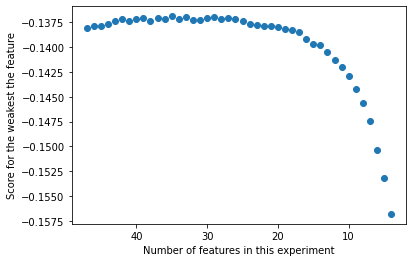

In [19]:
min_features_required=3
model=XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
n_splits=3

scoring = "neg_root_mean_squared_error"
y = df['target']
X = df.drop("target",axis=1)
print("Scoring funtion: ",scoring)
results = feature_ranking_elimination(X,y, min_features_required, scoring, model, n_splits)

output_file_name = str(input_file.stem)+"_"+scoring+"_1feb.pkl"
file = open(output_file_name, 'wb')
pickle.dump(results, file)
file.close()


plot_1_data = []
for exp_no in results.keys():
        plot_1_data.append((exp_no,results[exp_no]["lowest_score"]))

plt.scatter(*zip(*plot_1_data))
plt.gca().invert_xaxis()
# plt.ylim(0,0.5)
plt.xlabel("Number of features in this experiment")
plt.ylabel("Score for the weakest the feature")
plt.show()

# Recursive feature elimination with cross-validation - sklearn

In [5]:
input_files = [
    Path("../data/formated_dataset.csv"),
    Path("../data/scaler_df.csv"),
    Path("../data/quantile_df.csv"),
    Path("../data/max_abs_df.csv")    
]     

## using r2 scoring 

In [10]:
%%time
%%memit



input_file = input_files[2]
print("Start processing using: ",input_file)
df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
y = df['target'].values
X = df.drop("target",axis=1).values

model = XGBRegressor(objective='reg:squarederror',tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
# rfecv = RFECV(estimator=model,min_features_to_select=4)
rfecv = RFECV(estimator=model)

pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])

cv = KFold(n_splits=3,shuffle=True, random_state=3)    
cv_scores = cross_val_score(pipeline, X, y, scoring='r2', cv=cv, n_jobs=-1, verbose=2)
pipeline.fit(X,y)


mean_score = np.mean(cv_scores)
print("cv_scores: ", cv_scores)
# summarize all features
X = df.drop("target",axis=1)
for i in range(X.shape[1]):
    print("Feature Name: ",X.columns.values[i])
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))

print('Optimal number of features : %d' % rfecv.n_features_)
print("Grid Scores: ", rfecv.grid_scores_)


Start processing using:  ../data/quantile_df.csv


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.2min finished


cv_scores:  [0.77025925 0.77225369 0.77132045]
Feature Name:  relief_elev_focalrange1000m_3s
Column: 0, Selected True, Rank: 1.000
Feature Name:  LONGITUDE_GRID1_clip
Column: 1, Selected True, Rank: 1.000
Feature Name:  LOC_distance_to_coast
Column: 2, Selected True, Rank: 1.000
Feature Name:  ceno_euc_aust1
Column: 3, Selected True, Rank: 1.000
Feature Name:  clim_EPA_albers
Column: 4, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata
Column: 5, Selected False, Rank: 7.000
Feature Name:  relief_roughness
Column: 6, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata
Column: 7, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata
Column: 8, Selected True, Rank: 1.000
Feature Name:  dem_fill
Column: 9, Selected True, Rank: 1.000
Feature Name:  Dose_2016
Column: 10, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-GREEN.filled.lzw.nodata
Column: 11, Selected False, Rank: 8.00

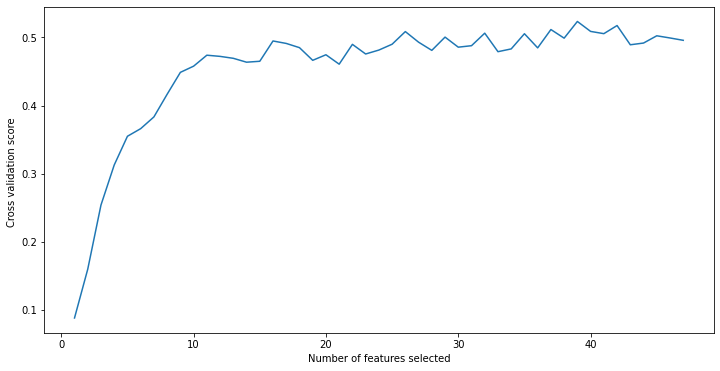

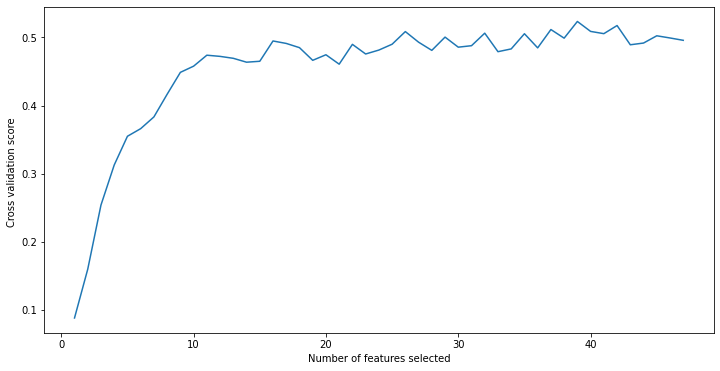

peak memory: 814.80 MiB, increment: 0.48 MiB
CPU times: user 247 ms, sys: 54.1 ms, total: 301 ms
Wall time: 441 ms


In [11]:
%%time
%%memit

plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score ')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [12]:
rfecv.estimator_  

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [13]:
data_1_itration = {}
for i,ranking in enumerate(rfecv.ranking_):
    data_1_itration[X.columns.values[i]]=ranking
    

sorted_data_1_itration = {k: v for k, v in sorted(data_1_itration.items(), key=lambda item: item[1])}
for k in sorted_data_1_itration:
    print(k, data_1_itration[k])

relief_elev_focalrange1000m_3s 1
LONGITUDE_GRID1_clip 1
LOC_distance_to_coast 1
ceno_euc_aust1 1
clim_EPA_albers 1
relief_roughness 1
be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata 1
be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata 1
dem_fill 1
Dose_2016 1
be-30y-85m-avg-SWIR1.filled.lzw.nodata 1
LATITUDE_GRID1_clip 1
Potassium_2016 1
Clim_Prescott_LindaGregory 1
relief_mrvbf_3s_mosaic 1
Rad2016U_Th 1
mrvbf_9 1
clim_RSM_albers 1
3dem_mag2 1
relief_elev_focalrange300m_3s 1
3dem_mag1_fin 1
be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata 1
clim_PTA_albers 1
be-30y-85m-avg-RED.filled.lzw.nodata 1
be-30y-85m-avg-SWIR2.filled.lzw.nodata 1
3dem_mag0.fin 1
si_geol1 1
national_Wii_RF_multirandomforest_prediction 1
Thorium_2016 1
Grav_lane_clip 1
Rad2016K_Th 1
tpi_300 1
clim_WDA_albers 1
be-l8-all-85m-avg-BLUE.filled.lzw.nodata 1
s2-dpca-85m_1 1
water-85m_1 1
water-85m_2 1
water-85m_3 1
saga_wetSM_85_reprojected 1
be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata 2
s2-dpca-85m_2 3
be-l8-all-85m-avg-NIR.f

## using neg_root_mean_squared_error scoring 

In [27]:
def get_important_features(dataset_file_path,model=None,n_splits=3,scoring='r2'):
    print("Start time: ",time.ctime())
    start_time = time.time()
    
    input_file = input_files[2]
    print("Start processing using: ",dataset_file_path)
    df = pd.read_csv(dataset_file_path).astype('float32')
    df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
    y = df['target']
    X = df.drop("target",axis=1)
    
    if model == None:
        model = XGBRegressor(objective='reg:squarederror',tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
    
    # rfecv = RFECV(estimator=model,min_features_to_select=4)
    rfecv = RFECV(estimator=model,cv=n_splits,scoring=scoring)    
    rfecv.fit(X,y)
    
    
    for i in range(X.shape[1]):
        print("Feature Name: ",X.columns.values[i])
        print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))
    
    print('Optimal number of features : %d' % rfecv.n_features_)
    
    plt.figure(figsize=(12,6))
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score ')
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    print(rfecv.grid_scores_)
    elapsed_time = time.time() - start_time
    print("Elapsed time: ",elapsed_time)
#     return selected_features, model_used, model_mean_score


Start time:  Fri Feb  5 13:45:48 2021
Start processing using:  ../data/quantile_df.csv
Feature Name:  relief_elev_focalrange1000m_3s
Column: 0, Selected True, Rank: 1.000
Feature Name:  LONGITUDE_GRID1_clip
Column: 1, Selected True, Rank: 1.000
Feature Name:  LOC_distance_to_coast
Column: 2, Selected True, Rank: 1.000
Feature Name:  ceno_euc_aust1
Column: 3, Selected True, Rank: 1.000
Feature Name:  clim_EPA_albers
Column: 4, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata
Column: 5, Selected False, Rank: 7.000
Feature Name:  relief_roughness
Column: 6, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata
Column: 7, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata
Column: 8, Selected True, Rank: 1.000
Feature Name:  dem_fill
Column: 9, Selected True, Rank: 1.000
Feature Name:  Dose_2016
Column: 10, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-GREEN.filled.lzw.nodat

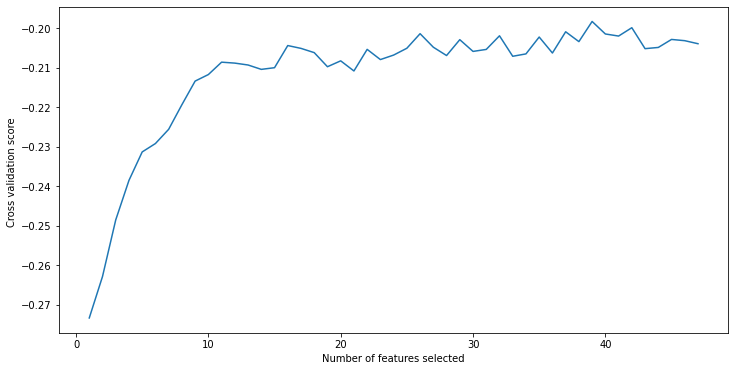

[-0.27331429 -0.26283166 -0.24849929 -0.23849213 -0.2312922  -0.22916737
 -0.22556809 -0.21934081 -0.21336253 -0.21171075 -0.20857488 -0.20881338
 -0.20929089 -0.2103964  -0.20997498 -0.20436946 -0.20508585 -0.2061603
 -0.20972824 -0.20823851 -0.21080075 -0.20533526 -0.20791743 -0.20677869
 -0.205053   -0.20136712 -0.20478722 -0.20689541 -0.20288097 -0.20585159
 -0.20534873 -0.20190078 -0.20708383 -0.20648058 -0.20221278 -0.20625766
 -0.20088215 -0.20337353 -0.19827328 -0.2014394  -0.20196522 -0.19985387
 -0.20515428 -0.20484835 -0.20282156 -0.20313732 -0.20390568]
Elapsed time:  208.28983783721924


In [29]:
import time
dataset_file_path = input_files[2]
model = XGBRegressor(objective='reg:squarederror',tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
n_splits=5
scoring='neg_root_mean_squared_error'

get_important_features(dataset_file_path,model=model,n_splits=n_splits,scoring=scoring)

Start time:  Fri Feb  5 13:39:24 2021
Start processing using:  ../data/quantile_df.csv
Feature Name:  relief_elev_focalrange1000m_3s
Column: 0, Selected True, Rank: 1.000
Feature Name:  LONGITUDE_GRID1_clip
Column: 1, Selected True, Rank: 1.000
Feature Name:  LOC_distance_to_coast
Column: 2, Selected True, Rank: 1.000
Feature Name:  ceno_euc_aust1
Column: 3, Selected True, Rank: 1.000
Feature Name:  clim_EPA_albers
Column: 4, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata
Column: 5, Selected False, Rank: 7.000
Feature Name:  relief_roughness
Column: 6, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata
Column: 7, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata
Column: 8, Selected True, Rank: 1.000
Feature Name:  dem_fill
Column: 9, Selected True, Rank: 1.000
Feature Name:  Dose_2016
Column: 10, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-GREEN.filled.lzw.nodat

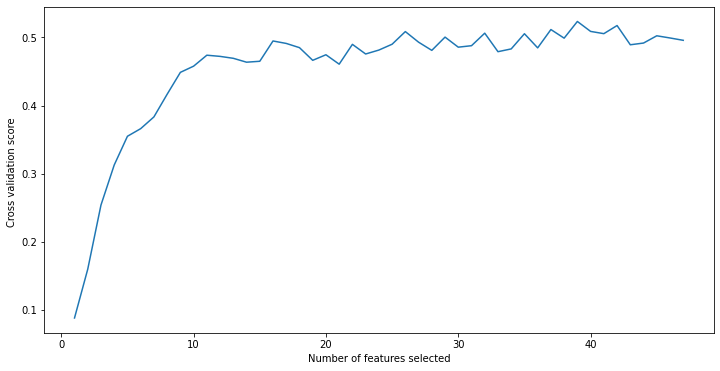

[0.08806694 0.15970799 0.25391869 0.31267962 0.35489387 0.36607063
 0.38331194 0.41658997 0.4487308  0.45783347 0.47392081 0.47219565
 0.46936015 0.46365667 0.46500634 0.4948143  0.49120489 0.48500994
 0.46640379 0.47458139 0.46074483 0.48985078 0.4757036  0.48147173
 0.49004403 0.50860347 0.49304523 0.48102815 0.50049314 0.48571847
 0.48787679 0.50625918 0.47908241 0.4831681  0.50545103 0.48469516
 0.51160572 0.49895198 0.52346484 0.50886519 0.50555405 0.51748084
 0.48924306 0.49177289 0.50242833 0.49922289 0.49578759]
Elapsed time:  208.214688539505


In [28]:
import time
dataset_file_path = input_files[2]
model = XGBRegressor(objective='reg:squarederror',tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
n_splits=5
scoring='r2'

get_important_features(dataset_file_path,model=model,n_splits=n_splits,scoring=scoring)

In [6]:
%%time
%%memit

print("Start time: ",time.ctime())
start_time = time.time()

input_file = input_files[2]
print("Start processing using: ",input_file)
df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
y = df['target'].values
X = df.drop("target",axis=1).values

model = XGBRegressor(objective='reg:squarederror',tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
# rfecv = RFECV(estimator=model,min_features_to_select=4)
rfecv = RFECV(estimator=model)

pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])

cv = KFold(n_splits=3,shuffle=True, random_state=3)    
cv_scores = cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose=2)
pipeline.fit(X,y)


mean_score = np.mean(cv_scores)
print("cv_scores: ", cv_scores)
# summarize all features
X = df.drop("target",axis=1)
for i in range(X.shape[1]):
    print("Feature Name: ",X.columns.values[i])
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))

print('Optimal number of features : %d' % rfecv.n_features_)
print("Grid Scores: ", rfecv.grid_scores_)

elapsed_time = time.time() - start_time
print("Elapsed time: ",elapsed_time)

Start processing using:  ../data/quantile_df.csv


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.2min finished


cv_scores:  [-0.13873874 -0.13809311 -0.13837075]
Feature Name:  relief_elev_focalrange1000m_3s
Column: 0, Selected True, Rank: 1.000
Feature Name:  LONGITUDE_GRID1_clip
Column: 1, Selected True, Rank: 1.000
Feature Name:  LOC_distance_to_coast
Column: 2, Selected True, Rank: 1.000
Feature Name:  ceno_euc_aust1
Column: 3, Selected True, Rank: 1.000
Feature Name:  clim_EPA_albers
Column: 4, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata
Column: 5, Selected False, Rank: 7.000
Feature Name:  relief_roughness
Column: 6, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata
Column: 7, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata
Column: 8, Selected True, Rank: 1.000
Feature Name:  dem_fill
Column: 9, Selected True, Rank: 1.000
Feature Name:  Dose_2016
Column: 10, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-GREEN.filled.lzw.nodata
Column: 11, Selected False, Rank: 8

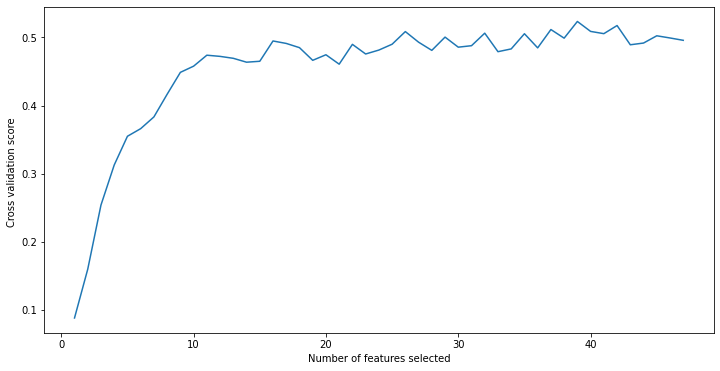

peak memory: 785.49 MiB, increment: 1.73 MiB
CPU times: user 199 ms, sys: 29.8 ms, total: 229 ms
Wall time: 491 ms


In [7]:
%%time
%%memit

plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score ')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [8]:
rfecv.estimator_  

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [9]:
data_1_itration = {}
for i,ranking in enumerate(rfecv.ranking_):
    data_1_itration[X.columns.values[i]]=ranking
    

sorted_data_1_itration = {k: v for k, v in sorted(data_1_itration.items(), key=lambda item: item[1])}
for k in sorted_data_1_itration:
    print(k, data_1_itration[k])

relief_elev_focalrange1000m_3s 1
LONGITUDE_GRID1_clip 1
LOC_distance_to_coast 1
ceno_euc_aust1 1
clim_EPA_albers 1
relief_roughness 1
be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata 1
be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata 1
dem_fill 1
Dose_2016 1
be-30y-85m-avg-SWIR1.filled.lzw.nodata 1
LATITUDE_GRID1_clip 1
Potassium_2016 1
Clim_Prescott_LindaGregory 1
relief_mrvbf_3s_mosaic 1
Rad2016U_Th 1
mrvbf_9 1
clim_RSM_albers 1
3dem_mag2 1
relief_elev_focalrange300m_3s 1
3dem_mag1_fin 1
be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata 1
clim_PTA_albers 1
be-30y-85m-avg-RED.filled.lzw.nodata 1
be-30y-85m-avg-SWIR2.filled.lzw.nodata 1
3dem_mag0.fin 1
si_geol1 1
national_Wii_RF_multirandomforest_prediction 1
Thorium_2016 1
Grav_lane_clip 1
Rad2016K_Th 1
tpi_300 1
clim_WDA_albers 1
be-l8-all-85m-avg-BLUE.filled.lzw.nodata 1
s2-dpca-85m_1 1
water-85m_1 1
water-85m_2 1
water-85m_3 1
saga_wetSM_85_reprojected 1
be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata 2
s2-dpca-85m_2 3
be-l8-all-85m-avg-NIR.f